## 0. 라이브러리

In [1]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from soynlp.normalizer import *
from tqdm import tqdm
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import numpy as np

## 1. 데이터 불러오기

In [2]:
train_data_path ="~/aiffel/dktc/data2/train4.csv"
train_data = pd.read_csv(train_data_path,index_col=0)
train_data

,class,conversation
idx,,
0,갈취 대화,손 들어 있는 돈 다꺼내\n까약 강도다!!\n돈 다 꺼내 놓고 밖으로 나가\n알겠어...
1,기타 괴롭힘 대화,야 핫스팟 좀 켜 봐\n나 데이터 없는데.\n지금 그럼 카톡 어떻게 보내고 있는데\...
2,협박 대화,? 예상이 가지? 대화를 하러 왔어.\n 눈을 가리고 의자에 묶어둔 채로?\n 거절...
3,갈취 대화,어머님! 지금 뭐하시는 거에요?\n아가? 너 다짜고짜 그게 무슨 말이니?\n어머님이...
4,일반 대화,취업 할때 자기소개서 쓰는데 어렵지 않았어?\n나는 너무 힘들었어\n그치? 면접보는...
...,...,...
4945,기타 괴롭힘 대화,저기요 아랫집에서 왔습니다.\n어머 무슨일이세요?\n아니 일부러 시끄럽게 쿵쿵거려놓...
4946,기타 괴롭힘 대화,우리가족은 다 날씬하고 예쁜데 너만 왜이러니?\n나는 내 모습에 만족해 그만해\n뭘...
4947,기타 괴롭힘 대화,사장님?\n네 말씀하세요.\n제가 어제 여기서 딸기를 구입했는데.\n네 무슨 문제라...


## 2. 데이터 준비 (Data preparation)
### 2.1-1 전처리 함수 정의

In [3]:
def preprocess_sentence(sentence):
    # synolp
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    #sentence = re.sub(r'[^\w\s]', '', sentence)
    # base preprocess
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣?.!,])', " ", sentence)
    sentence = re.sub(r'!+', '!', sentence)
    sentence = re.sub(r'\?+', '?', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 엔터 구분 (\n)
    sentence = sentence.replace("\n", "<EOL>")
    sentence = sentence.strip()
    return sentence

### 2.1-2 전처리 함수 적용

In [4]:
# 학습할 문장이 담길 배열
sentences = []

for val in tqdm(train_data['conversation']):
    sentences.append(preprocess_sentence(val))

100%|██████████| 4950/4950 [00:01<00:00, 3333.15it/s]


### 2.2 최대 길이 지정

In [5]:
MAX_LEN = 250

### 2.3 class(label) 인코딩

In [6]:
from sklearn.preprocessing import LabelEncoder

CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화','일반 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
labels = train_data['class']

len(labels)

4950

In [7]:
class_mapping = {class_name: encoder.transform([class_name])[0] for class_name in CLASS_NAMES}
print("Class mapping:", class_mapping)

Class mapping: {'협박 대화': 4, '갈취 대화': 0, '직장 내 괴롭힘 대화': 3, '기타 괴롭힘 대화': 1, '일반 대화': 2}


In [8]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, 
                                    max_length=max_seq_len, 
                                    pad_to_max_length=True,
                                   )
        
        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        
        # token_type_id은 세그먼트 인코딩
        token_type_id = [0] * max_seq_len
        
        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)
    
    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    
    data_labels = np.asarray(data_labels, dtype=np.int32)
    
    return (input_ids, attention_masks, token_type_ids), data_labels

### 2.4 train-val

In [9]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42, stratify=labels)

In [10]:
# train data 증강

def random_deletion(words, p=0.3):
    if len(words) == 1:
        return words

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return [words[rand_int]]

    return "".join(new_words)

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0

    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1
        if counter > 3:
            return new_words

    new_words[random_idx_1], new_words[random_idx_2] = (
        new_words[random_idx_2],
        new_words[random_idx_1],
    )
    return new_words


def random_swap(words, n=3):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)

    return new_words


print("before data augmentation: ", len(train_sentences))

train_splted = pd.DataFrame({ "sentence": train_sentences, "class": train_labels })

# random deletion
train_splted_rd = train_splted.copy()
train_splted_rd["sentence"] = train_splted_rd["sentence"].apply(random_deletion)

# random swap
train_splted_rs = train_splted.copy()

# with data augmentation
train_concated = pd.concat([train_splted , train_splted_rd , train_splted_rs])

print("after data augmentation: ", len(train_concated))

train_concated

before data augmentation:  3960
after data augmentation:  11880


,sentence,class
idx,,
2646,진짜 참다참다 말하는건데 내가 누구라고는 말 안하겠지만 직장생활 하면서 옷은 빨아입...,3
2463,게임 하면서 불미스러운 일은 없었어요 ? 저도 보긴 했어요 무슨 일이 였는데요 ? ...,2
4293,여보 수영 배워 본다며 알아봤어 ? 가 코로나로 계속 안해 언니 진짜 수영 배울라고...,2
4124,어이 꼬마야 돈좀 있냐 ? 없어요 . 주머니 뒤져서 나오면 원마다 한대씩이다 ? 없...,0
2377,이야 너 많이 컸다 ? 어 . ? 그냥 찐따 멸치 새낀 줄 알았는데 여자랑 다닐 줄...,1
...,...,...
251,저 부장님 . 드릴말씀이 있는데요 . 어 김사원 . 뭔데 말해봐 . 제가 이번에 남...,3
1801,내가 하라는 대로 안 하면 네 동영상 인터넷에 올릴거야 . 뭐 ? 네가 진짜 이럴 ...,4
1514,자동차는 뭐에요 ? 저는 아반떼에요 . 연비는 좋나요 ? 신형은 연비 엄청 좋다고 ...,2


In [11]:
train_sentences, train_labels = train_concated["sentence"], train_concated["class"]
print(len(train_sentences))

11880


## 3. 모델
### 3.1-1 토크나이저 정의

In [12]:
# BERT 토크나이저와 모델 준비
model_name = "klue/bert-base"

tokenizer = BertTokenizer.from_pretrained(model_name)
special_tokens_dict = {'additional_special_tokens': ['<EOL>']}
tokenizer.add_special_tokens(special_tokens_dict)

1

### 3.1-2 토크나이저 적용

In [13]:
# 데이터셋을 BERT 입력 형식으로 변환
X_train, y_train = convert_examples_to_features(
    train_sentences, train_labels, 
    max_seq_len=MAX_LEN, tokenizer=tokenizer
)
X_valid, y_valid = convert_examples_to_features(
    val_sentences, val_labels, 
    max_seq_len=MAX_LEN, tokenizer=tokenizer
)

# train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=MAX_LEN) # 뒤쪽에 패딩
# val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=MAX_LEN)

  0%|          | 0/11880 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 990/990 [00:00<00:00, 1080.81it/s]


### 3.2 모델 준비

In [14]:
class TFBertForMultiClassClassification(tf.keras.Model):
    def __init__(self, model_name, num_classes, dropout_rate=0.1):
        super(TFBertForMultiClassClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.classifier = tf.keras.layers.Dense(num_classes,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                kernel_regularizer=l2(0.01),
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        cls_token = outputs[1]
        dropped = self.dropout(cls_token)
        prediction = self.classifier(dropped)
        return prediction

In [15]:
model = TFBertForMultiClassClassification(model_name, num_classes=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

### 3.3 파라미터

In [16]:
BATCH_SIZE = 16
lr = 5e-5
EPOCH = 10

### 3.4 TF 데이터셋 생성

In [17]:
# TensorFlow 데이터셋 생성
# train_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(X_train),
#     y_train
# )).shuffle(100).batch(BATCH_SIZE)

# val_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(X_valid),
#     y_valid
# )).batch(BATCH_SIZE)


### 3.5 모델 컴파일

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### 3.6 모델 훈련

### 3.6-1 콜백 설정

In [19]:
import datetime 

early_stopping = EarlyStopping(
    monitor='val_loss',    # 검증 손실을 모니터링
    patience=2,            # 3 에포크 동안 개선되지 않으면 중지
    restore_best_weights=True  # 최상의 가중치를 복원
)

now = datetime.datetime.now()
time = now.strftime("%y-%m-%d %H:%M")
data_type = 0

checkpoint = ModelCheckpoint(
    filepath='best_model_weights.h5',  # 모델 가중치를 저장할 파일 경로
    monitor='val_loss',        # 검증 손실을 모니터링
    save_best_only=True,       # 최상의 모델만 저장
    save_weights_only=True,    # 저장 (가중치)
    mode='min',                # 'val_loss'가 최소일 때 저장
    verbose=1                  # 저장 시 로그 출력
)

### 3.6-2 모델 훈련

In [20]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
372/372 [==============================] - 628s 2s/step - loss: 0.4280 - accuracy: 0.8841 - val_loss: 0.3486 - val_accuracy: 0.9232

Epoch 00001: val_loss improved from inf to 0.34859, saving model to best_model_weights.h5
Epoch 2/10
372/372 [==============================] - 611s 2s/step - loss: 0.1705 - accuracy: 0.9728 - val_loss: 0.3884 - val_accuracy: 0.9242

Epoch 00002: val_loss did not improve from 0.34859
Epoch 3/10
372/372 [==============================] - 611s 2s/step - loss: 0.1199 - accuracy: 0.9875 - val_loss: 0.4757 - val_accuracy: 0.9061

Epoch 00003: val_loss did not improve from 0.34859


### 3.6-3 모델 훈련 시각화

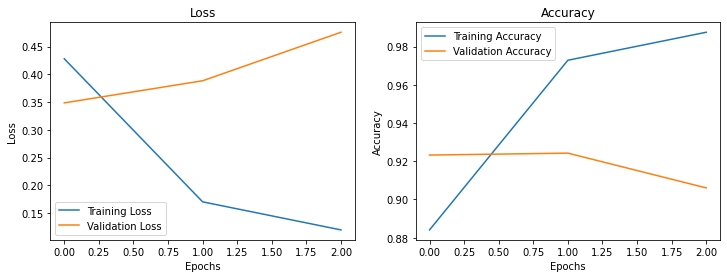

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 3.7 모델 평가

In [22]:
# 모델 평가
evaluation = model.evaluate(X_valid, y_valid)
print("평가 결과:", evaluation)

31/31 [==============================] - 17s 547ms/step - loss: 0.3486 - accuracy: 0.9232
평가 결과: [0.3485882878303528, 0.9232323169708252]


### 3.8 f1score

In [23]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np 

def score(model, val):
    X, y = val
    # 실제 예측값 생성
    real_predictions = model.predict(X)

    # 예측값을 레이블로 변환
    real_predicted_labels = np.argmax(real_predictions, axis=1)

    # 정확도 계산
    real_accuracy = accuracy_score(y, real_predicted_labels)
    print(f"Real Accuracy: {real_accuracy:.4f}")

    # 분류 보고서 생성
    real_report = classification_report(y, real_predicted_labels, target_names=[f"Class {i}" for i in range(5)])
    print(real_report)

    # F1 스코어 계산
    real_f1 = f1_score(y, real_predicted_labels, average='weighted')
    print(f"\nWeighted F1 Score (based on real predictions): {real_f1:.4f}")

In [24]:
score(model, (X_valid, y_valid))

Real Accuracy: 0.9232
              precision    recall  f1-score   support

     Class 0       0.87      0.91      0.89       196
     Class 1       0.90      0.86      0.88       219
     Class 2       1.00      0.99      0.99       200
     Class 3       0.95      0.97      0.96       196
     Class 4       0.90      0.89      0.89       179

    accuracy                           0.92       990
   macro avg       0.92      0.92      0.92       990
weighted avg       0.92      0.92      0.92       990


Weighted F1 Score (based on real predictions): 0.9232


### AUC-ROC 커브

AUC Score: 0.9899


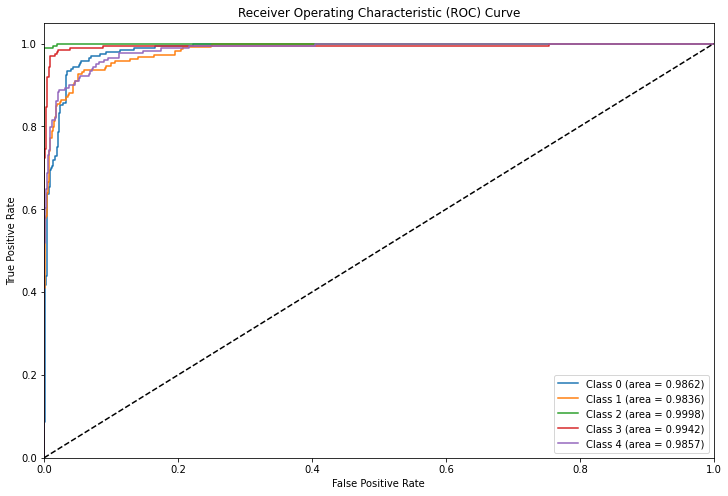

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

def plot_auc_roc(model, val, n_classes):
    X, y = val
    # 실제 예측값 생성
    real_predictions = model.predict(X)
    
    # 레이블을 이진화
    y_bin = label_binarize(y, classes=[i for i in range(n_classes)])

    # AUC 점수 계산
    auc = roc_auc_score(y_bin, real_predictions, multi_class="ovr")
    print(f"AUC Score: {auc:.4f}")

    # 각 클래스별 AUC-ROC 커브 그리기
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], real_predictions[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], real_predictions[:, i])

    # ROC 커브 그리기
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

n_classes = 5
plot_auc_roc(model, (X_valid, y_valid), n_classes)

### 혼동행렬

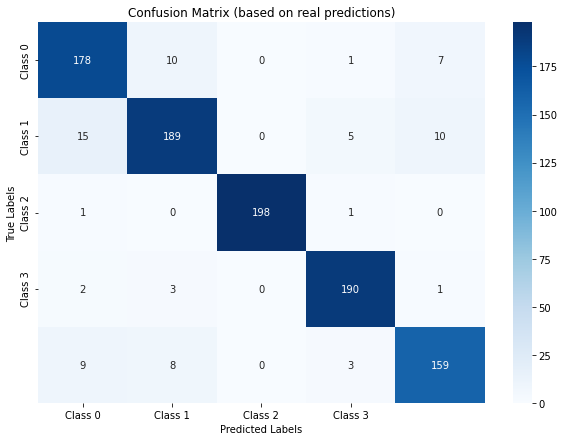

In [26]:
# 혼동 행렬 생성 및 표시
import seaborn as sns
real_predictions = model.predict(X_valid)
real_predicted_labels = np.argmax(real_predictions, axis=1)
real_conf_matrix = confusion_matrix(y_valid, real_predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(real_conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=[f"Class {i}" for i in range(4)], yticklabels=[f"Class {i}" for i in range(4)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (based on real predictions)')
plt.show()

## 4. 모델 적용

In [27]:
import json

test_data_path = "/aiffel/aiffel/dktc/data/test.json"
test = pd.read_json(test_data_path).transpose()

In [29]:
import numpy as np

test_predict = []

for idx, value in test.iterrows():

    test_sentence = value["text"]
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="tf")

    test_predictions = model.predict(
        (test_encodings["input_ids"],
         test_encodings["attention_mask"],
         test_encodings["token_type_ids"])
    )
    test_class_probabilities = tf.nn.softmax(test_predictions, axis=-1).numpy() # [[0.13297564 0.8358507  0.00801584 0.02315779]]
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) # [ 1 ]
    test_predict.append(test_predicted_class[0])

In [30]:
# {'협박 대화': 4, '갈취 대화': 0, '직장 내 괴롭힘 대화': 3, '기타 괴롭힘 대화': 1, '일반 대화': 2}
#   협박 대화 : 0,  갈취 대화 : 1,  직장 내 괴롭힘 대화 : 2,  기타 괴롭힘 대화 : 3,  일반 대화 : 4
def labelnum_to_text(x):
    if x == 0:
        return '01'
    if x == 1:
        return '03'
    if x == 2:
        return '04'
    if x == 3:
        return '02'
    if x == 4:
        return '00'

submission = pd.read_csv("~/aiffel/dktc/data/new_submission.csv")
submission["class"] = [ labelnum_to_text(pred) for pred in test_predict ]

submission.to_csv('~/aiffel/dktc/data2/submission_004.csv')

In [ ]:
# submission 

In [ ]:
submission